In [2]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
from neuralforecast.models import PatchTST
from neuralforecast.auto import AutoPatchTST
from neuralforecast.core import NeuralForecast
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

In [21]:
# Load your OHLCV or Close-only data
file_path = '/content/EURUSD15.csv'
df = pd.read_csv(file_path , sep='\t' , names=['Time' ,'open','high' , 'low','close','volume'])# df['date'] = pd.to_datetime(df['date'])
df['Time'] = pd.to_datetime(df['Time'])


# Ensure correct format for neuralforecast
hf_df = pd.DataFrame({
    'unique_id': 'EURUSD',
    'ds': df['Time'],
    'y': df['close']
})

df

,Time,open,high,low,close,volume
0,2017-03-29 19:00:00,1.07578,1.07648,1.07569,1.07637,1279
1,2017-03-29 19:15:00,1.07636,1.07729,1.07610,1.07652,2140
2,2017-03-29 19:30:00,1.07652,1.07683,1.07644,1.07672,1474
3,2017-03-29 19:45:00,1.07673,1.07733,1.07660,1.07715,1683
4,2017-03-29 20:00:00,1.07715,1.07719,1.07631,1.07636,1653
...,...,...,...,...,...,...
195583,2025-04-07 23:45:00,1.09160,1.09183,1.09129,1.09146,1111
195584,2025-04-08 00:00:00,1.09147,1.09260,1.09146,1.09251,2263
195585,2025-04-08 00:15:00,1.09252,1.09354,1.09204,1.09348,2453
195586,2025-04-08 00:30:00,1.09348,1.09442,1.09343,1.09418,1969


In [23]:
scaler = MinMaxScaler()
hf_df['y'] = scaler.fit_transform(hf_df[['y']])

In [24]:
# Example: last 100 steps as validation
horizon = 10
val_size = 200

train_df = hf_df[:-val_size]
val_df = hf_df[-(val_size + horizon):]  # for evaluation


In [42]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MAE
from pytorch_lightning.callbacks import EarlyStopping

horizon = 24

patchtst = PatchTST(
    h=horizon,
    input_size=60,
    max_steps=1000,
    batch_size=32,
    learning_rate=1e-3,
    loss=MAE(),
    scaler_type='identity',
    dropout=0.1,
    n_heads=8,
    # n_layers=4,     # <-- Model parameter
    # d_model=256,    # <-- Model parameter
    # trainer_kwargs={
    #     'callbacks': [EarlyStopping(monitor='val_loss', patience=10)]
    # }
)

nf = NeuralForecast(models=[patchtst], freq='15min')
nf.fit(df=train_df)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 422 K  | train
-----------------------------------------------------------
422 K     Trainable params
3         Non-trainable params
422 K     Total params
1.688     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [43]:
forecast_df = nf.predict()
print(forecast_df.head(horizon))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

   unique_id                  ds  PatchTST
0     EURUSD 2025-04-03 20:00:00  0.494105
1     EURUSD 2025-04-03 20:15:00  0.494468
2     EURUSD 2025-04-03 20:30:00  0.494321
3     EURUSD 2025-04-03 20:45:00  0.493798
4     EURUSD 2025-04-03 21:00:00  0.493820
5     EURUSD 2025-04-03 21:15:00  0.493845
6     EURUSD 2025-04-03 21:30:00  0.493742
7     EURUSD 2025-04-03 21:45:00  0.493609
8     EURUSD 2025-04-03 22:00:00  0.493743
9     EURUSD 2025-04-03 22:15:00  0.493626
10    EURUSD 2025-04-03 22:30:00  0.493693
11    EURUSD 2025-04-03 22:45:00  0.493866
12    EURUSD 2025-04-03 23:00:00  0.493446
13    EURUSD 2025-04-03 23:15:00  0.493791
14    EURUSD 2025-04-03 23:30:00  0.494019
15    EURUSD 2025-04-03 23:45:00  0.493310
16    EURUSD 2025-04-04 00:00:00  0.493696
17    EURUSD 2025-04-04 00:15:00  0.493202
18    EURUSD 2025-04-04 00:30:00  0.493398
19    EURUSD 2025-04-04 00:45:00  0.493418
20    EURUSD 2025-04-04 01:00:00  0.493304
21    EURUSD 2025-04-04 01:15:00  0.493521
22    EURUS

In [44]:
forecast_df

,unique_id,ds,PatchTST
0,EURUSD,2025-04-03 20:00:00,0.494105
1,EURUSD,2025-04-03 20:15:00,0.494468
2,EURUSD,2025-04-03 20:30:00,0.494321
3,EURUSD,2025-04-03 20:45:00,0.493798
4,EURUSD,2025-04-03 21:00:00,0.493820
5,EURUSD,2025-04-03 21:15:00,0.493845
6,EURUSD,2025-04-03 21:30:00,0.493742
7,EURUSD,2025-04-03 21:45:00,0.493609
8,EURUSD,2025-04-03 22:00:00,0.493743
9,EURUSD,2025-04-03 22:15:00,0.493626


In [45]:

forecast_df['y_hat_inv'] = scaler.inverse_transform(forecast_df[['PatchTST']])

In [46]:
forecast_df

,unique_id,ds,PatchTST,y_hat_inv
0,EURUSD,2025-04-03 20:00:00,0.494105,1.102759
1,EURUSD,2025-04-03 20:15:00,0.494468,1.102868
2,EURUSD,2025-04-03 20:30:00,0.494321,1.102824
3,EURUSD,2025-04-03 20:45:00,0.493798,1.102666
4,EURUSD,2025-04-03 21:00:00,0.493820,1.102673
5,EURUSD,2025-04-03 21:15:00,0.493845,1.102681
6,EURUSD,2025-04-03 21:30:00,0.493742,1.102650
7,EURUSD,2025-04-03 21:45:00,0.493609,1.102610
8,EURUSD,2025-04-03 22:00:00,0.493743,1.102650
9,EURUSD,2025-04-03 22:15:00,0.493626,1.102615


<Axes: >

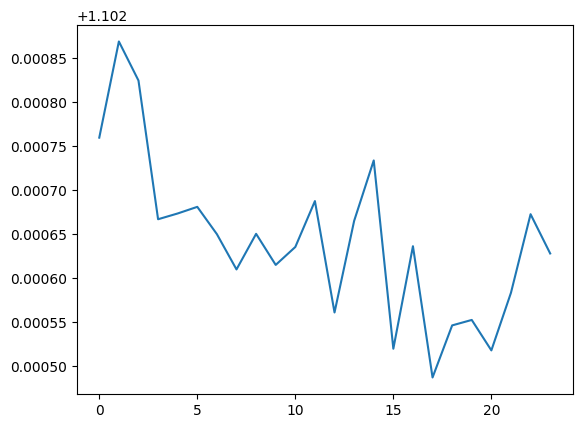

In [47]:
forecast_df['y_hat_inv'].plot()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# مثال: إذا كانت بياناتك الحقيقية والتنبؤات موجودة في الأعمدة
# df_eval['y'] = الحقيقية
# df_eval['y_hat'] = التنبؤ

metrics = evaluate_forecast(df_eval['y'], df_eval['y_hat'])
print(metrics)


NameError: name 'df_eval' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_eval['ds'], df_eval['y'], label='Actual')
plt.plot(df_eval['ds'], df_eval['y_hat'], label='Forecast')
plt.legend()
plt.title("PatchTST Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()
